In this notebook we look at how to use the gradient of the horsetail matching metric to speed up optimizations (in terms of number of evaluations of the quantity of interest).

In [1]:
import numpy
import matplotlib.pyplot as plt

from horsetailmatching import UniformParameter, IntervalParameter, HorsetailMatching
from horsetailmatching.demoproblems import TP1, TP2

First we will look at the purely probabilistic case and a simple test problem. We set up the uncertain parameters and create the horsetail matching object as usual.

In [2]:
u1 = UniformParameter(lower_bound=-1, upper_bound=1)
u2 = UniformParameter(lower_bound=-1, upper_bound=1)
input_uncertainties = [u1, u2]

Horsetail matching uses the same syntax for specifying a gradient as the scipy.minimize function: through the 'jac' argument. If 'jac' is True, then horsetail matching expects the qoi function to also return the jacobian of the qoi (the gradient with respect to the design variables). Alternatively 'jac' is a fuction that takes two inputs (the values of the design variables and uncertainties), and returns the gradient. The following code demonstrates these alternatives:

In [3]:
def fun_qjac(x, u):
    return TP1(x, u, jac=True)  # Returns both qoi and its gradient

def fun_q(x, u): 
    return TP1(x, u, jac=False)  # Returns just the qoi

def fun_jac(x, u):
    return TP1(x, u, jac=True)[1]  # Returns just the gradient

theHM = HorsetailMatching(fun_qjac, input_uncertainties, jac=True, method='kernel', kernel_bandwidth=0.001,
                          samples_prob=2000, integration_points=numpy.linspace(-10, 100, 5000))

theHM = HorsetailMatching(fun_q, input_uncertainties, jac=fun_jac, method='empirical', samples_prob=2000)

print(theHM.evalMetric([1,1]))

(0.5660927168329217, array([0.56609272, 0.56609272]))


The gradient can be evaluated using either the 'empirical' or 'kernel' based methods, however the 'empirical' method can sometimes give discontinuous gradients and so in general the 'kernel' based method is preferred.

Note that when we are using kernels to evaluate the horsetail plot (with the method 'kernel'), it is important to provide integration points that cover the range of values of q that designs visited in the optimization might reach. Integrations points far beyond the range of samples are not evaluated and so this range can be made to be large without taking a computational penalty.
Additionally, here we specified the kernel_bandwidth which is fixed throughout an optimization. If this is not specified, Scott's rule is used on the samples from the initial design to determine the bandwidth. 

Now we can use this in a gradient based optimizer:

In [4]:
from scipy.optimize import minimize

solution = minimize(theHM.evalMetric, x0=[1,1], method='BFGS', jac=True)
print(solution)

   status: 0
  success: True
     njev: 3
     nfev: 3
 hess_inv: array([[1.38324754, 0.38324754],
       [0.38324754, 1.38324754]])
      fun: 2.511947323349104e-31
        x: array([-6.66133815e-16, -6.66133815e-16])
  message: 'Optimization terminated successfully.'
      jac: array([-3.77093501e-16, -3.77093501e-16])


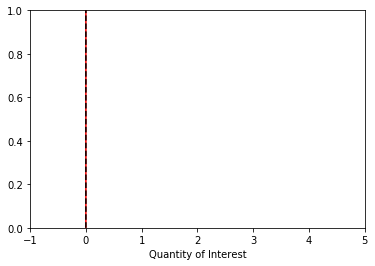

In [5]:
(x1, y1, t1), (x2, y2, t2), CDFs = theHM.getHorsetail()

for (x, y) in CDFs:
    plt.plot(x, y, c='grey', lw=0.5)
plt.plot(x1, y1, 'r')
plt.plot(t1, y1, 'k--')
plt.xlim([-1, 5])
plt.ylim([0, 1])
plt.xlabel('Quantity of Interest')
plt.show()

Once again the optimizer has found the optimum where the CDF is a step function, but this time in fewer iterations. 

We can also use gradients for optimization under mixed uncertainties in exactly the same way. The example below performs the optimization of TP2 like in the mixed uncertainties tutorial, but this time using gradients. Note that we turn on the verbosity so we can see what the horsetail matching object is doing at each design point. 

In [8]:
def fun_qjac(x, u):
    return TP2(x, u, jac=True)  # Returns both qoi and its gradient

u1 = UniformParameter()
u2 = IntervalParameter()

theHM = HorsetailMatching(fun_qjac, u1, u2, jac=True, method='kernel',
                          samples_prob=500, samples_int=50, integration_points=numpy.linspace(-20, 100, 3000),
                          verbose=True)

In [9]:
solution = minimize(theHM.evalMetric, x0=[1, 1], method='BFGS', jac=True)
print(solution)

----------
At design: [1 1]
Evaluating surrogate
Getting uncertain parameter samples
Evaluating quantity of interest at samples
Evaluating metric
Metric: 14.202468068
Gradient: [0.017510992821455792, 0.3901026587041186]
----------
At design: [1 1]
Evaluating surrogate
Re-using stored samples
Evaluating quantity of interest at samples
Evaluating metric
Metric: 14.202468068
Gradient: [0.017510992821455792, 0.3901026587041186]
----------
At design: [0.98248901 0.60989734]
Evaluating surrogate
Re-using stored samples
Evaluating quantity of interest at samples
Evaluating metric
Metric: 14.0516455442
Gradient: [0.017145712348092677, 0.3819031893046833]
----------
At design: [ 0.91244504 -0.95051329]
Evaluating surrogate
Re-using stored samples
Evaluating quantity of interest at samples
Evaluating metric
Metric: 13.4749679035
Gradient: [0.01596868398395644, 0.35565950244702904]
----------
At design: [ 0.63226915 -7.19215583]
Evaluating surrogate
Re-using stored samples
Evaluating quantity of 

To plot the optimum solution...

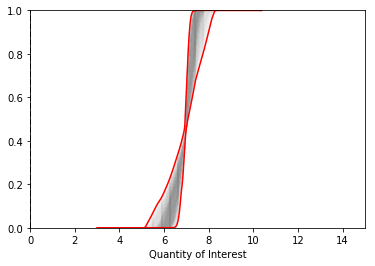

In [10]:
upper, lower, CDFs = theHM.getHorsetail()
(q1, h1, t1) = upper
(q2, h2, t2) = lower

for CDF in CDFs:
    plt.plot(CDF[0], CDF[1], c='grey', lw=0.05)
plt.plot(q1, h1, 'r')
plt.plot(q2, h2, 'r')
plt.plot(t1, h1, 'k--')
plt.plot(t2, h2, 'k--')
plt.xlim([0, 15])
plt.ylim([0, 1])
plt.xlabel('Quantity of Interest')
plt.show()

We can see that using gradients we found the minimum after visiting about an order of magnitude fewer design points than were required without using gradients in the mixed uncertainties tutorial.

This concludes our illustration of using horsetail matching with gradients. In the next tutorial we illustrate how we can change the target to specify preferences about the desired behavior under uncertainty: http://nbviewer.jupyter.org/github/lwcook/horsetail-matching/blob/master/notebooks/Targets.ipynb

For other tutorials, please visit http://www-edc.eng.cam.ac.uk/aerotools/horsetailmatching/